In [1]:
import os
os.chdir('/home/megatron/work')

import megatron
import pandas as pd
import numpy as np
import sqlite3
from sklearn.decomposition import PCA

In [2]:
# example using pandas
generator = False
lahman_file = 'data/lahman_csv/core/Batting.csv'
lahman = pd.read_csv(lahman_file)
exclude = ['playerID','yearID','stint','teamID','lgID']

if generator:
    lahman_generator = megatron.io.generator.PandasGenerator(lahman, 1000,
                                                             exclude_cols=exclude)
else:
    lahman_data = megatron.io.dataset.PandasData(lahman, exclude_cols=exclude)
    
inputs = megatron.nodes.from_dataframe(lahman, exclude_cols=exclude)

In [2]:
# example using csv
generator = True
lahman_file = 'data/lahman_csv/core/Batting.csv'
exclude = ['playerID','yearID','stint','teamID','lgID']

if generator:
    lahman_generator = megatron.io.generator.CSVGenerator(lahman_file, 1000,
                                                          exclude_cols=exclude)
else:
    lahman_data = megatron.io.dataset.CSVData(lahman_file, exclude_cols=exclude)
    
inputs = megatron.nodes.from_csv(lahman_file, exclude_cols=exclude, eager=False)

In [ ]:
# example using sql database

# make sql database from csv
lahman_df = pd.read_csv('data/lahman_csv/core/Batting.csv')
conn = sqlite3.connect('lahman')
conn.execute('DROP TABLE IF EXISTS batting')
lahman_df.to_sql('batting', conn, index=False)

generator = True
conn = sqlite3.connect('lahman')
query = 'SELECT * FROM batting'

if generator:
    lahman_generator = megatron.io.generator.SQLGenerator(conn, query, 1000)
else:
    lahman_data = megatron.io.dataset.SQLData(conn, query)
    
inputs = megatron.nodes.from_sql(conn, query, eager=False)

In [3]:
fillna = megatron.layers.Impute({np.nan: 0})
inputs = fillna(inputs)
inputs = megatron.layers.Cast(np.int)(inputs)

# helpers
def single_fn(h, d, t, hr):
    return h - d - t - hr
singles = megatron.layers.Lambda(single_fn)(inputs[['H','2B','3B','HR']], 'Singles')
hit_types = megatron.layers.Concatenate()([singles]+inputs[['2B','3B','HR']], 'hit_types')
TB = megatron.layers.Dot(W=np.array([1,2,3,4]))(hit_types, 'TB')

# basics
PA = megatron.layers.Add()(inputs[['AB', 'BB', 'HBP', 'SH', 'SF']], 'PA')
BBp = megatron.layers.Divide()([inputs['BB'], PA], 'BBpct')
Kp = megatron.layers.Divide()([inputs['SO'], PA], 'Kpct')
def obp(h, bb, hbp, ab, sf):
    return megatron.helpers.safe_divide(h + bb + hbp, ab + bb + hbp + sf)
OBP = megatron.layers.Lambda(obp)(inputs[['H','BB','HBP','AB','SF']], 'OBP')
SLG = megatron.layers.Divide()([TB, inputs['AB']], 'SLG')
AVG = megatron.layers.Divide()(inputs[['H', 'AB']], 'AVG')
ISO = megatron.layers.Subtract()([SLG, AVG], 'ISO')
def babip(h, hr, ab, k, sf):
    return megatron.helpers.safe_divide(h - hr, ab - k - hr + sf)
BABIP = megatron.layers.Lambda(babip)(inputs[['H','HR','AB','SO','SF']], 'BABIP')

features = megatron.layers.Concatenate()([PA, BBp, Kp, OBP, SLG, AVG, ISO, BABIP])
pca = megatron.layers.SklearnLayer(PCA(n_components=3))(features, 'pc')

storage = sqlite3.connect('data/megatron_default.db')
P = megatron.Pipeline(inputs, pca, name='test', version=0.3, storage=storage)

In [4]:
if generator:
    P.fit_generator(lahman_generator)
    features = P.transform_generator(lahman_generator)
else:
    P.fit(lahman_data)
    features = P.transform(lahman_data)

In [5]:
stored = P.storage.read(lookup=['0', '1'])
stored['pc']

array([[-154.34405541,   -0.31705808,   -0.18260463],
       [ -36.34364338,    0.17075174,   -0.16682739]])

In [6]:
pca.metadata['components_']

array([[ 9.99999676e-01,  9.28689694e-05, -1.42929824e-04,
         3.72316088e-04,  5.10491800e-04,  3.12640995e-04,
         1.97850738e-04,  2.87903399e-04],
       [-7.82284222e-04,  6.71032478e-02, -2.77683009e-03,
         4.58523908e-01,  5.89893317e-01,  4.13142696e-01,
         1.76750908e-01,  4.85121387e-01],
       [ 1.48712647e-04, -3.08113934e-03,  9.94255545e-01,
        -3.59404555e-02, -2.12305320e-02, -3.53431257e-02,
         1.41125588e-02,  9.08605648e-02]])

In [5]:
P.save('/home/megatron/work/')

In [3]:
storage_db = sqlite3.connect('data/megatron_default.db')
P = megatron.load_pipeline('/home/megatron/work/test.pkl', storage_db)

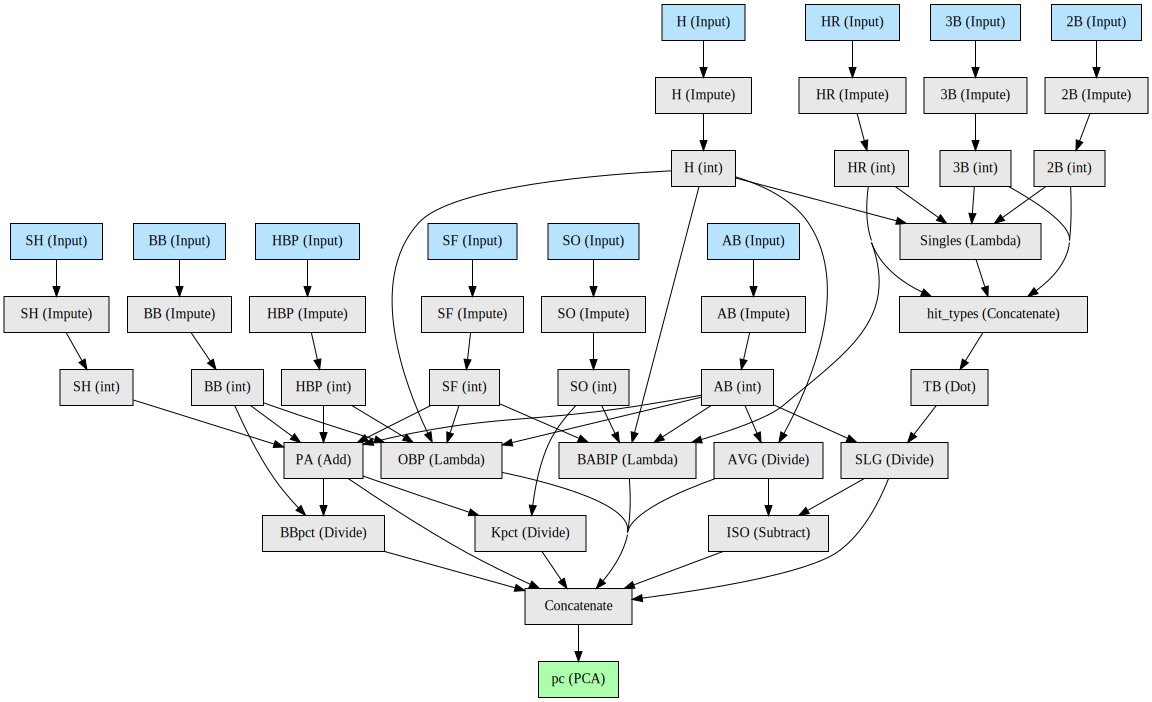

In [5]:
megatron.visuals.pipeline_imsave(P, 'img/sabermetrics.png')
megatron.visuals.pipeline_imshow(P)